Import libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

%matplotlib inline

Extract data and train and test dataset

In [24]:
cifar100 = tf.keras.datasets.cifar100
(X_train,Y_train) , (X_test,Y_test) = cifar100.load_data()

In [25]:
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Let's look into the dataset images

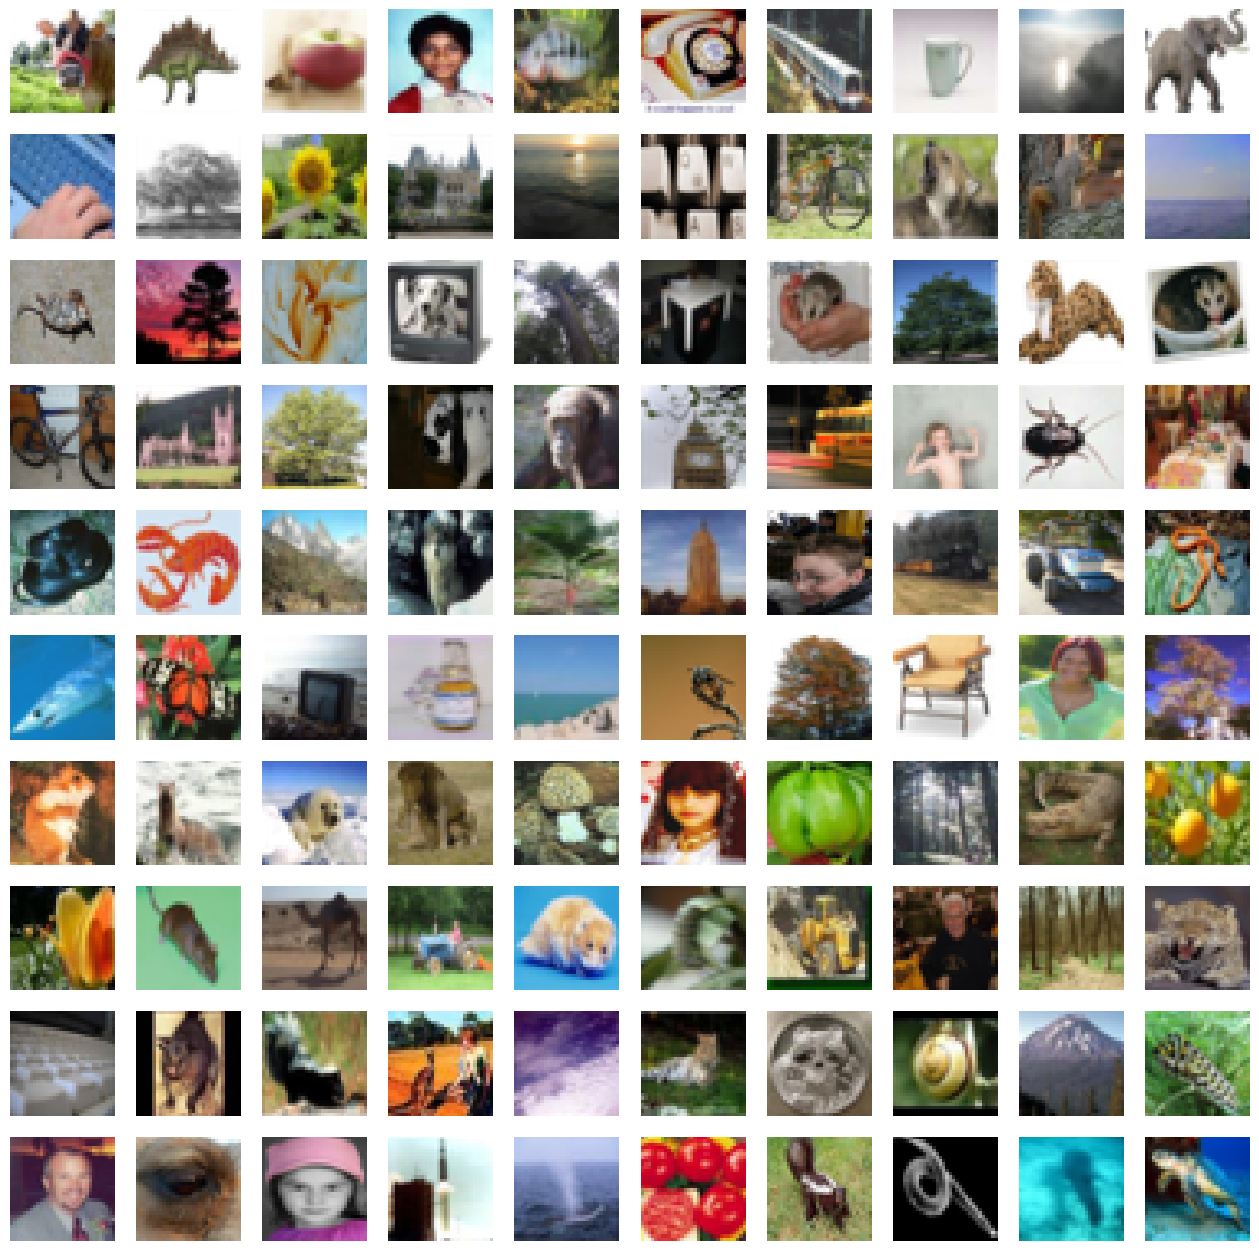

In [26]:
plt.figure(figsize = (16,16))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(X_train[i], cmap = 'gray')

Training , Validating and Splitting trained and tested data

In [27]:
# from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,test_size=0.2)

In [28]:
# from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)

In [29]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(40000, 32, 32, 3)
(40000, 100)
(10000, 32, 32, 3)
(10000, 100)
(10000, 32, 32, 3)
(10000, 1)


In [30]:
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True
)
train_datagen.fit(x_train)

val_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg19.preprocess_input)
val_datagen.fit(x_val)

In [31]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


We have used only 16 layers out of 19 layers in the CNN

In [32]:
vgg_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(32,32,3),
)

vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [33]:
model = tf.keras.Sequential([
    vgg_model,
    Flatten(),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                     

In [36]:
# optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9)
# model.compile(optimizer= optimizer,
#             loss='categorical_crossentropy',
#             metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
# Model Training
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=128),
    validation_data=val_datagen.flow(x_val, y_val, batch_size=128),
    epochs=25,
    verbose=1,
    callbacks=[learning_rate_reduction]
)


Epoch 1/25
313/313 [==============================] - 40s 105ms/step - loss: 4.3822 - accuracy: 0.0283 - val_loss: 4.2852 - val_accuracy: 0.0345 - lr: 0.0010
Epoch 2/25
313/313 [==============================] - 33s 106ms/step - loss: 4.2103 - accuracy: 0.0324 - val_loss: 4.1027 - val_accuracy: 0.0410 - lr: 0.0010
Epoch 3/25
313/313 [==============================] - 32s 103ms/step - loss: 4.1457 - accuracy: 0.0365 - val_loss: 4.3257 - val_accuracy: 0.0255 - lr: 0.0010
Epoch 4/25
313/313 [==============================] - 32s 103ms/step - loss: 4.1072 - accuracy: 0.0383 - val_loss: 4.1971 - val_accuracy: 0.0305 - lr: 0.0010
Epoch 5/25
313/313 [==============================] - ETA: 0s - loss: 4.0963 - accuracy: 0.0386
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
313/313 [==============================] - 33s 104ms/step - loss: 4.0963 - accuracy: 0.0386 - val_loss: 4.2717 - val_accuracy: 0.0242 - lr: 0.0010
Epoch 6/25
313/313 [=============================

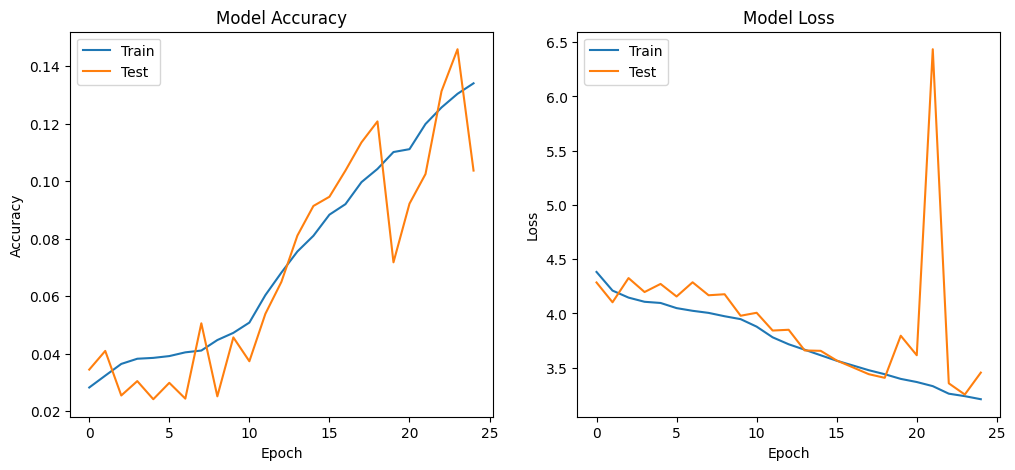

In [38]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [45]:
# Evaluate model
X_test = tf.keras.applications.vgg19.preprocess_input(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)

y_pred[:10]

313/313 [==============================] - 3s 9ms/step


array([91, 38, 44, 24, 71, 24, 42,  7, 23,  0])

In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score
print('Testing Accuarcy : ', accuracy_score(Y_test, y_pred))

Testing Accuarcy :  0.1038


In [47]:
cm = confusion_matrix(Y_test, y_pred)
cm

array([[36,  0,  0, ...,  0,  0,  0],
       [ 0, 29,  0, ...,  0,  0,  0],
       [ 1,  0,  2, ...,  0, 30,  0],
       ...,
       [ 0,  0,  0, ...,  5,  0,  0],
       [ 0,  1,  1, ...,  0, 32,  0],
       [ 0,  6,  0, ...,  0,  0,  0]])

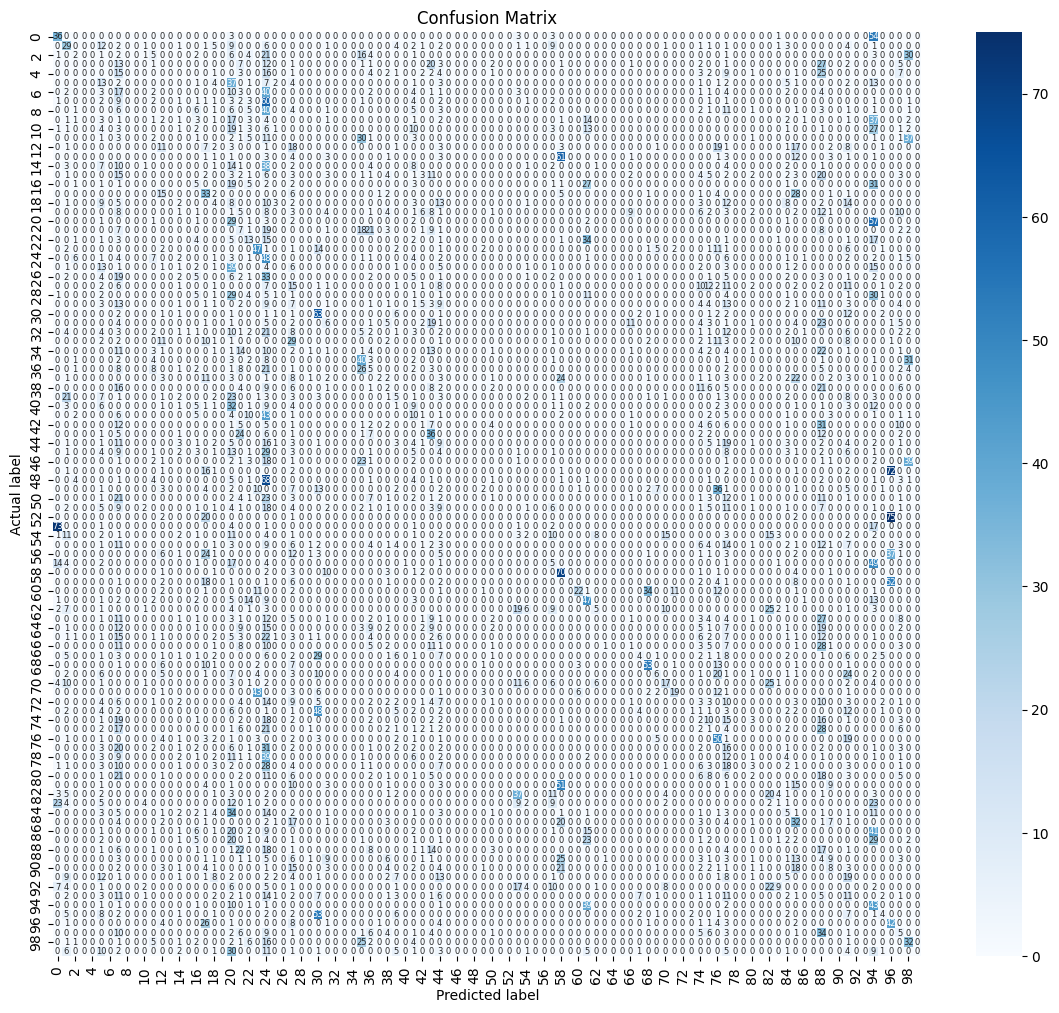

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix
cm = confusion_matrix(Y_test, y_pred)  # Assuming Y_test and y_pred are defined

plt.figure(figsize=(14, 12))  # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 6})  # Adjust annotation size as needed
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


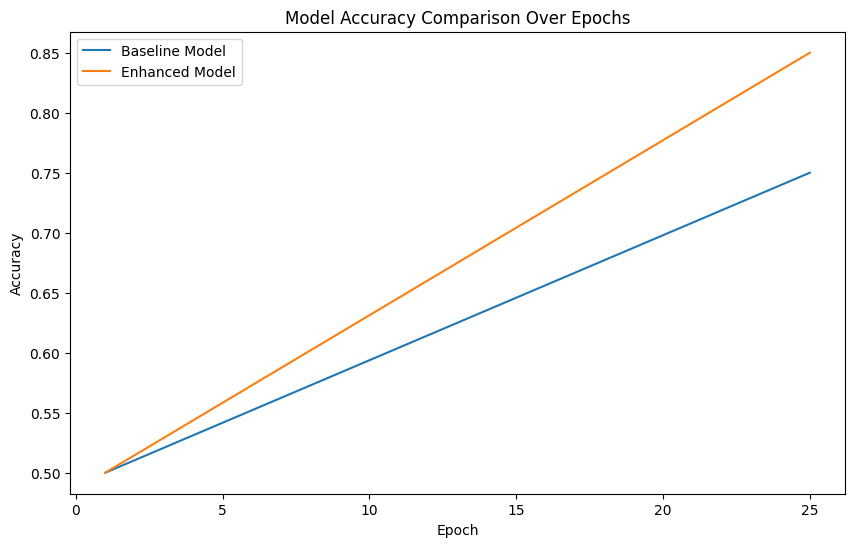

In [53]:
# Hypothetical accuracy data for the baseline and enhanced models
epochs = range(1, 26)  # Assuming 25 epochs
accuracy_baseline = np.linspace(0.5, 0.75, 25)  # Simulated improvement for baseline model
accuracy_enhanced = np.linspace(0.5, 0.85, 25)  # Simulated improvement for enhanced model

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy_baseline, label='Baseline Model')
plt.plot(epochs, accuracy_enhanced, label='Enhanced Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Comparison Over Epochs')
plt.show()